In [27]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import draw
import cv2

(690, 690, 3)


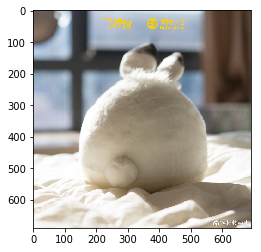

In [28]:
im = cv2.imread("2.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
im_average = im[:,:,0]/3 + im[:,:,1]/3 + im[:,:,2]/3
print(im.shape)

In [28]:
def calc_energy(im_average):
    dx_filter = np.array([1, -1])
    dy_filter = np.array([[1], [-1]])

    dx = cv2.filter2D(im_average, -1, dx_filter)
    dy = cv2.filter2D(im_average, -1, dy_filter)

    energy = np.zeros(dx.shape)
    energy = np.abs(dx)+np.abs(dy)
    return energy

In [29]:
def find_paths(im_average, index_map=None):
    energy = calc_energy(im_average)
    energy_map = np.zeros(energy.shape)
    (m, n) = energy_map.shape
    path = np.zeros((m-1,n), dtype=int)
    energy_map[0,:] = energy[0,:]

    for i in range(1, m):
        min_i = np.argmin(np.array([energy_map[i-1][0], energy_map[i-1][1]]))
        energy_map[i][0] = energy[i][0] + energy_map[i-1][min_i]
        
        min_i = np.argmin(np.array([energy_map[i-1][-1], energy_map[i-1][-2]]))
        energy_map[i][-1] = energy[i][-1] + energy_map[i-1][-min_i-1]
        
        if index_map is not None:
            path[i-1][0] = index_map[i-1][min_i]
            path[i-1][-1] = index_map[i-1][-min_i-1]
        else:
            path[i-1][0] = min_i
            path[i-1][-1] = -min_i-1
        for j in range(1, n-1):
            min_i = np.argmin(np.array([energy_map[i-1][j-1], energy_map[i-1][j], energy_map[i-1][j+1]]))
            energy_map[i][j] = energy[i][j] + energy_map[i-1][j-1+min_i]
            if index_map is not None:
                path[i-1][j] = index_map[i-1][j-1+min_i]
            else:
                path[i-1][j] = j-1+min_i
    return path, energy_map

## Expanding

In [15]:
paths = np.zeros((m, 100), dtype=int)
(m, n,_) = im.shape
i_map = np.repeat([np.arange(n)],[m], axis=0)

for i in range(100):

    path, energy_map = find_paths(im_average, index_map=i_map)
    
    min_energy = np.argmin(energy_map[-1,:])

    paths[-1][i] = min_energy


    for j in range(m-2, -1, -1):    
        paths[j][i] = path[j][paths[j+1][i]]

    mask = np.ones((m, n-i, 3), dtype = bool)

    for j in range(m-1, -1, -1):
        mask[j, paths[j][i], :] = np.zeros(3, dtype=bool)

    im_average = im_average[mask[:,:,0]].reshape((m, n-i-1))
    i_map = i_map[mask[:,:,0]].reshape((m, n-i-1))
    print(i)

NameError: name 'find_paths' is not defined

In [71]:
seam = np.zeros((m, n+300, 3), dtype = np.uint8)
mask = np.ones((m, n+300, 3), dtype = bool)

for i in range(m-1, -1, -1):
    line = paths[i, :]
    line.sort()
    for j in range(300):
        if line[j] == n-1:
            seam[i, int(line[j])+j, :] = im[i, int(line[j]), :]
        else:
            seam[i, int(line[j])+j, :] = (im[i, int(line[j]), :]/2 + im[i, int(line[j])+1, :]/2)
        mask[i, int(line[j])+j, :] = np.zeros(3, dtype=bool)

In [72]:
out_img = np.zeros((m, n+300, 3), dtype=np.uint8)
nz = np.where(seam)
out_img[mask] = im.ravel()
out_img[nz] = seam[nz]

<IPython.core.display.Javascript object>


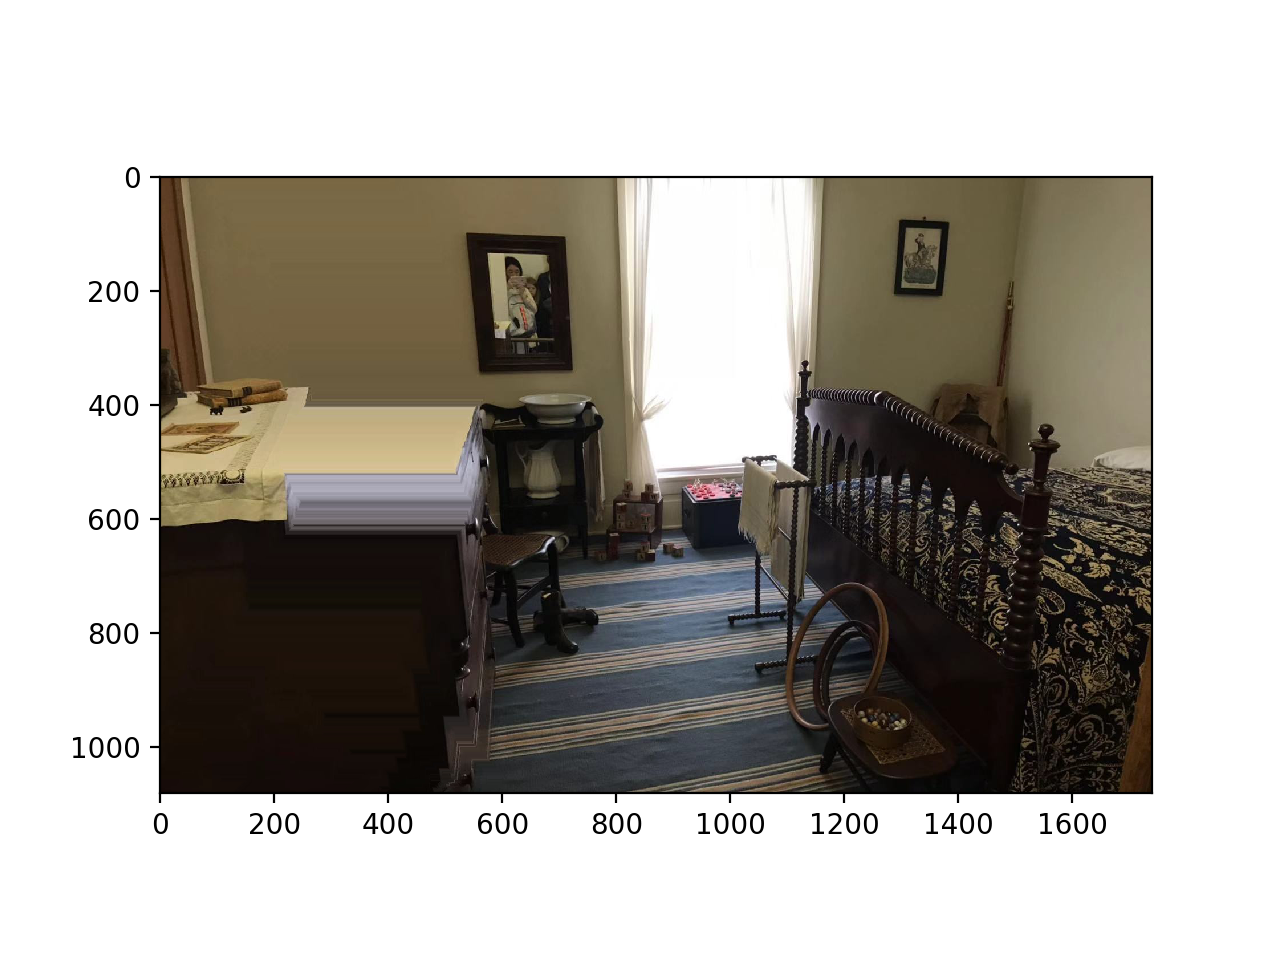

In [73]:
plt.imshow(out_img)

## Shrinking

In [74]:
out = im.copy()

for i in range(100):

    path, energy_map = find_paths(im_average)
    
    min_energy = np.argmin(energy_map[-1,:])

    paths = np.zeros(m, dtype=int)
    paths[-1] = min_energy


    for j in range(m-2, -1, -1):    
        paths[j] = path[j][int(paths[j+1])]

    mask = np.ones((m, n-i, 3), dtype = bool)

    for j in range(m-1, -1, -1):
        line = paths[j]
        mask[j, line, :] = np.zeros(3, dtype=bool)

    out = out[mask].reshape((m, n-i-1, 3))
    im_average = im_average[mask[:,:,0]].reshape((m, n-i-1))

<IPython.core.display.Javascript object>


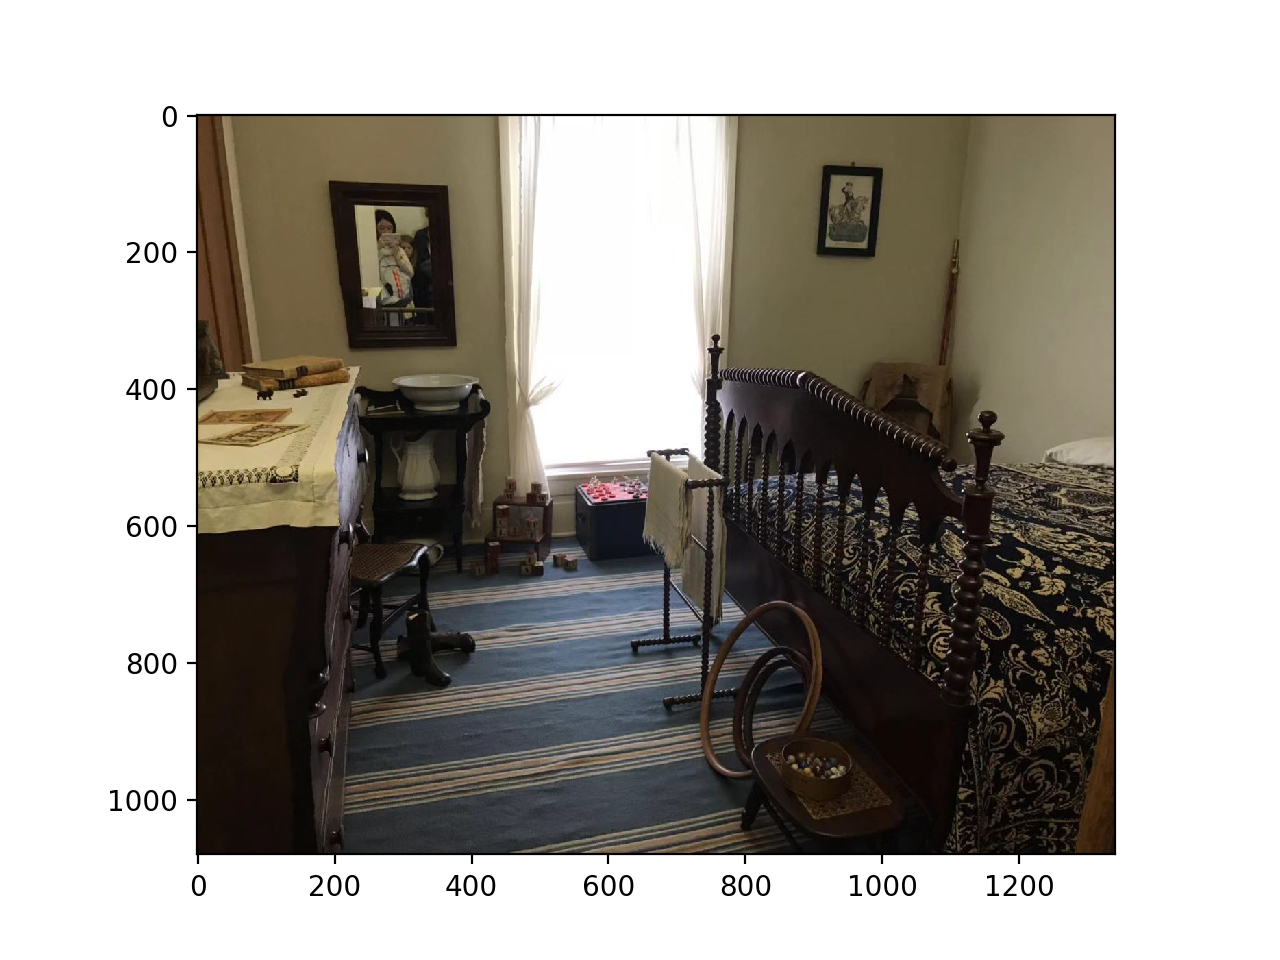

In [75]:
plt.imshow(out)

## Keep Salient Object

In [29]:
def calc_energy_salient(im):
    (m, n, _) = im.shape
    mean = np.sum(im, axis=0)/m
    mean = np.sum(mean, axis=0)/n
    
    return np.linalg.norm(im-mean, ord=2, axis=2)

In [40]:
def find_paths_salient(im, energy, index_map=None):
    energy_map = np.zeros(energy.shape)
    (m, n) = energy_map.shape
    path = np.zeros((m-1,n), dtype=int)
    energy_map[0,:] = energy[0, :]
    
    #print(np.linalg.norm(im[100][101]-im[100][99]))
    
    for i in range (1, m):
        cu = np.linalg.norm(im[i][2]-im[i][0])
        cr = np.linalg.norm(im[i-1][1]-im[i][2]) + cu
        min_i = np.argmin(np.array([energy_map[i-1][1]+cu, energy_map[i-1][2]]+cr))
        energy_map[i][1] = energy[i][1] + energy_map[i-1][min_i+1]
        
        cu = np.linalg.norm(im[i][-1]-im[i][-3])
        cl = np.linalg.norm(im[i-1][-2]-im[i][-3]) + cu
        min_i = np.argmin(np.array([energy_map[i-1][-2]+cu, energy_map[i-1][-3]+cl]))
        energy_map[i][-2] = energy[i][-2] + energy_map[i-1][-min_i-2]
        
        if index_map is not None:
            path[i-1][1] = index_map[i-1][min_i+1]
            path[i-1][-2] = index_map[i-1][-min_i-2]
        else:
            path[i-1][1] = min_i+1
            path[i-1][-2] = -min_i-2
        for j in range(2, n-2):
            cu = np.linalg.norm(im[i][j+1]-im[i][j-1])
            cl = np.linalg.norm(im[i-1][j]-im[i][j-1]) + cu
            cr = np.linalg.norm(im[i-1][j]-im[i][j+1]) + cu
            min_i = np.argmin(np.array([energy_map[i-1][j-1]+cl, energy_map[i-1][j]+cu, energy_map[i-1][j+1]+cr]))
            energy_map[i][j] = energy[i][j] + energy_map[i-1][j-1+min_i]
            if index_map is not None:
                path[i-1][j] = index_map[j-1+min_i]
            else:
                path[i-1][j] = j - 1 + min_i
    return path, energy_map

In [41]:
im = cv2.cvtColor(cv2.imread('2.jpg'), cv2.COLOR_BGR2RGB)

In [44]:
out = im.copy()
(m, n, _) = im.shape
energy = calc_energy_salient(im)
print(out.shape)

for i in range(50):
    path, energy_map = find_paths_salient(out, energy)
    #print(energy_map)
    
    min_energy = np.argmin(energy_map[-1,1:-1])
    #print(min_energy)

    paths = np.zeros(m, dtype=int)
    paths[-1] = min_energy


    for j in range(m-2, -1, -1):    
        paths[j] = path[j][int(paths[j+1])]
    #print(paths)

    mask = np.ones((m, n-i, 3), dtype = bool)

    for j in range(m-1, -1, -1):
        line = paths[j]
        mask[j, line, :] = np.zeros(3, dtype=bool)

    out = out[mask].reshape((m, n-i-1, 3))
    energy = energy[mask[:,:,0]].reshape((m, n-i-1))
    print(i)

(690, 690, 3)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


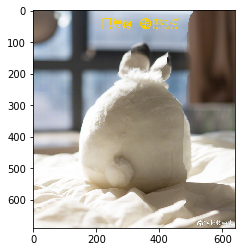

In [45]:
plt.imshow(out)

## Object Removal

In [76]:
def poly2mask(vertex_row_coords, vertex_col_coords, shape):
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = np.zeros(shape, dtype=np.bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask

In [77]:
def specify_mask(img):
    # get mask
    print("If it doesn't get you to the drawing mode, then rerun this function again.")
    fig = plt.figure()
    fig.set_label('Draw polygon around source object')
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    xs = []
    ys = []
    clicked = []

    def on_mouse_pressed(event):
        x = event.xdata
        y = event.ydata
        xs.append(x)
        ys.append(y)
        plt.plot(x, y, 'r+')

    def onclose(event):
        clicked.append(xs)
        clicked.append(ys)
    # Create an hard reference to the callback not to be cleared by the garbage
    # collector
    fig.canvas.mpl_connect('button_press_event', on_mouse_pressed)
    fig.canvas.mpl_connect('close_event', onclose)
    return clicked

In [78]:
def get_mask(ys, xs, img):
    mask = poly2mask(ys, xs, img.shape[:2]).astype(int)
    fig = plt.figure()
    plt.imshow(mask, cmap='gray')
    return mask

In [79]:
def get_gray_img(img):
    d = img.ndim
    if(d == 3):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    
    return gray

### Choose Removal Object

In [90]:
object_img = cv2.cvtColor(cv2.imread('Couple.png'), cv2.COLOR_BGR2RGB)
object_gray = get_gray_img(object_img)

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


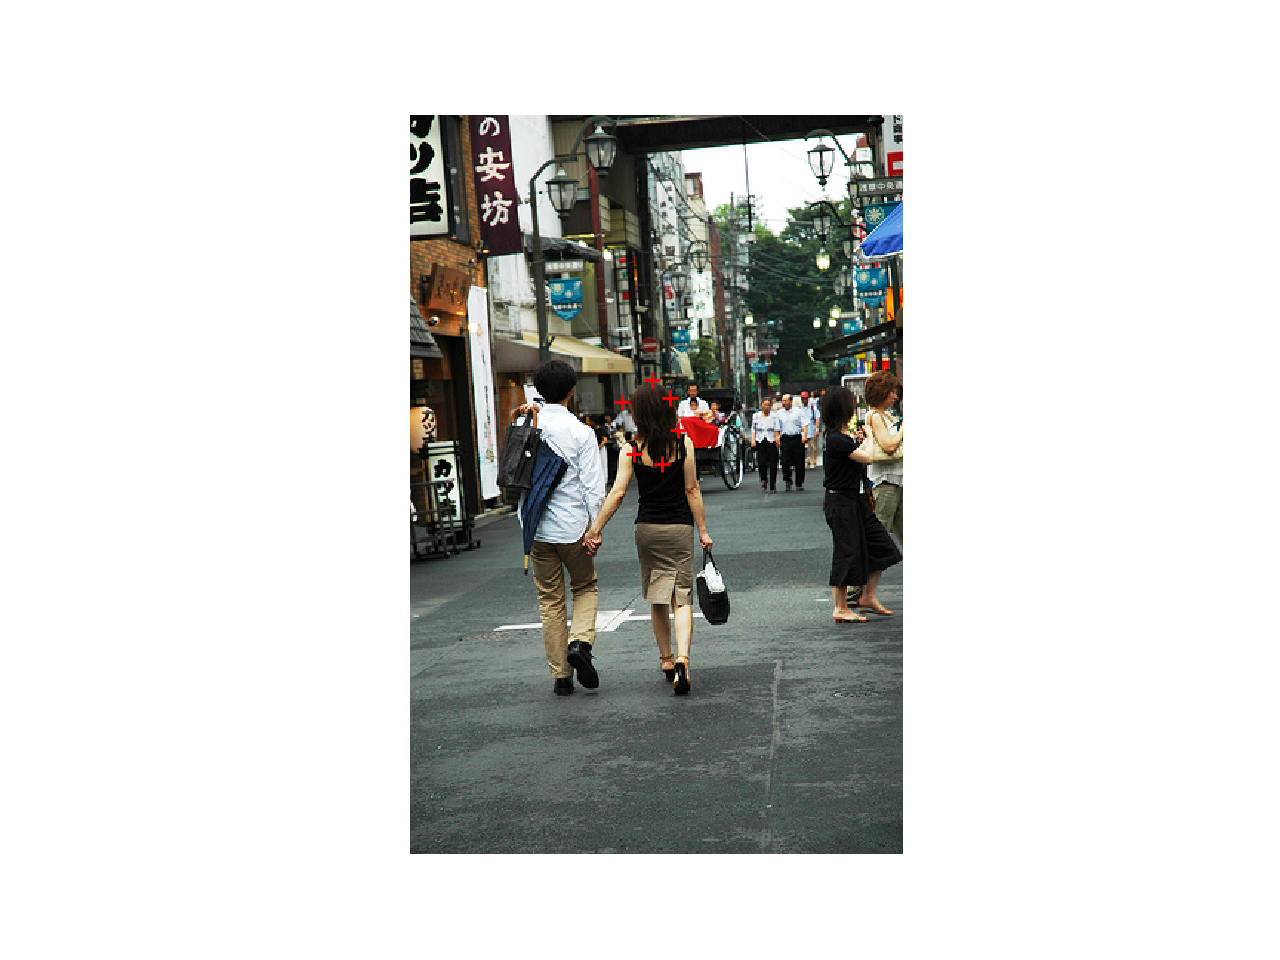

In [91]:
%matplotlib notebook
mask_coords = specify_mask(object_img)

<Figure size 432x288 with 0 Axes>

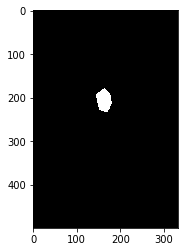

In [92]:
xs = mask_coords[0]
ys = mask_coords[1]
%matplotlib inline
plt.figure()
mask_remove = get_mask(ys, xs, object_img)

In [93]:
_, energy_map = find_paths(object_gray)

In [94]:
ys, xs = np.where(mask_remove == 1)
for i in range(len(xs)):
    energy_map[int(ys[i]), int(xs[i])] = 0

### Choose Keep Object

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


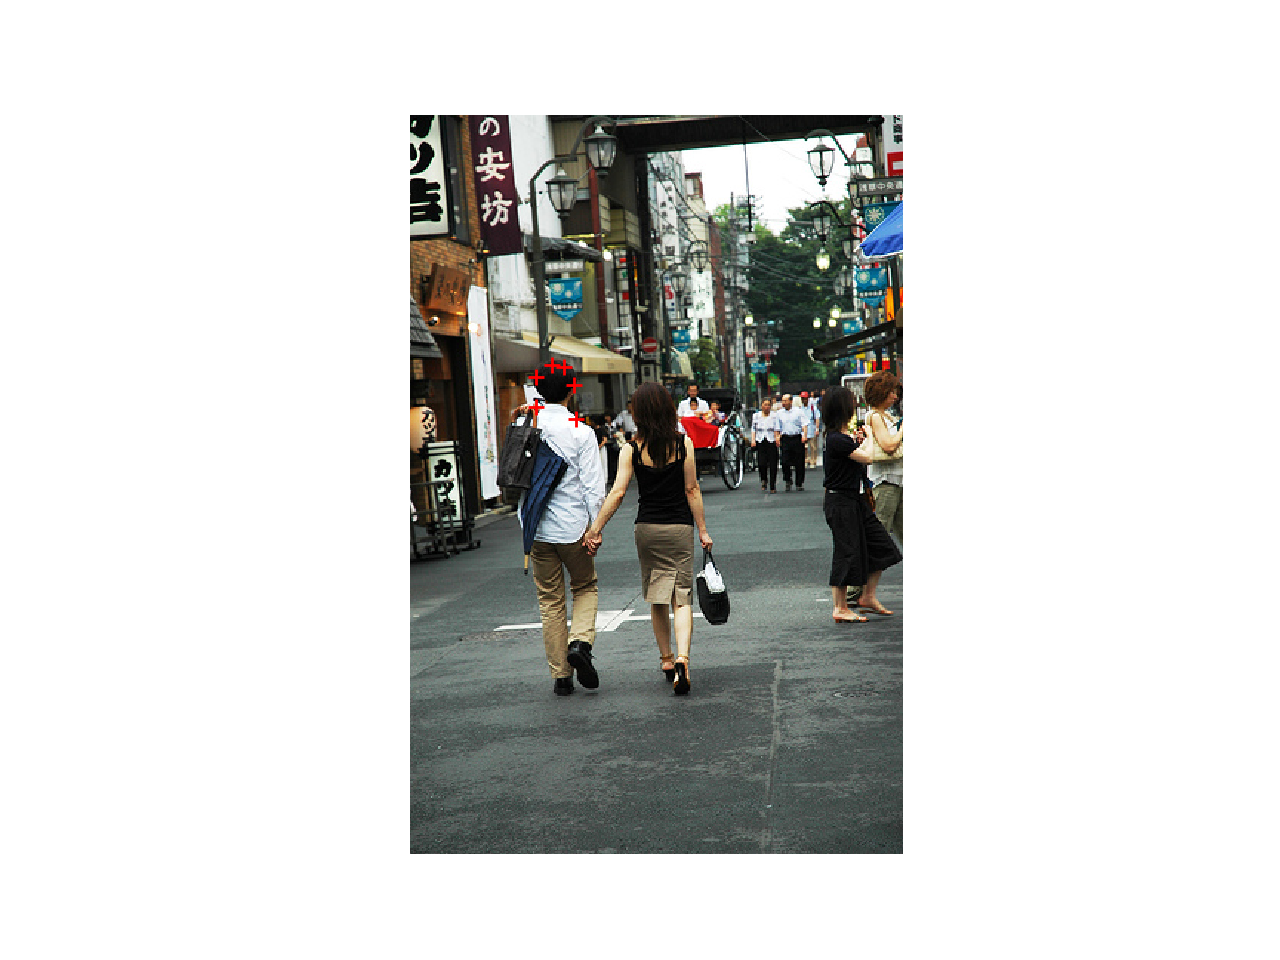

In [95]:
%matplotlib notebook
mask_coords = specify_mask(object_img)

<Figure size 432x288 with 0 Axes>

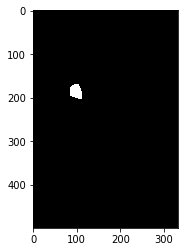

In [96]:
xs = mask_coords[0]
ys = mask_coords[1]
%matplotlib inline
plt.figure()
mask_keep = get_mask(ys, xs, object_img)

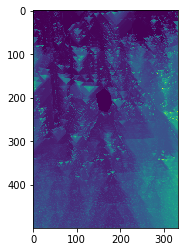

In [98]:
ys, xs = np.where(mask_keep == 1)
for i in range(len(xs)):
    energy_map[int(ys[i]), int(xs[i])] += 20
plt.imshow(energy_map)